<a href="https://colab.research.google.com/github/mch60131242/Home/blob/main/Titanic%2C_surivived_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### 어떤 데이터를 전처리했는지?
## 어떤 모델을 선택했는지


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from PIL import Image
from sklearn.tree import plot_tree,DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier,BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
combine = [train_df, test_df]

In [4]:
## 총 행의 갯수는 891개로 보인다. Age열에 891-714= 177개의 결측치가 존재하고 Cabin열에 687개의 결측치, Embarked열에 2개의 결측치가 존재한다.
## 데이터 타입의 형태는 [Name,Sex,Ticket,Embarked]은 object(string)형태이며 [PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare]는 int64,float64형태이다.
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


(0.0, 150.0)

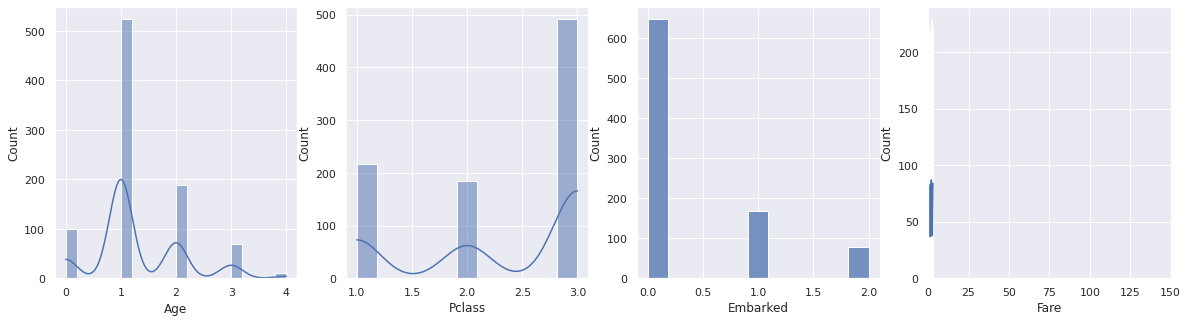

In [47]:
sns.set(style='darkgrid')

df= train_df

fig= plt.figure(figsize=(20,5))
ax1= fig.add_subplot(1,4,1)
ax2= fig.add_subplot(1,4,2)
ax3= fig.add_subplot(1,4,3)
ax4= fig.add_subplot(1,4,4)


sns.histplot(data=df, x='Age', kde=True, ax= ax1)

sns.histplot(data=df, x='Pclass', kde=True, ax= ax2)

sns.histplot(data=df, x='Embarked', kde=False, ax= ax3)


sns.histplot(data=df, x='Fare', kde=True, ax= ax4)
plt.xlim(0,150)

In [6]:

##현재의 데이터에서 PassengerId는 데이터의 순서를 나타내는 데이터일뿐 특별한 이유가 없는 데이터 이기에 삭제를 하고 
## Cabin 데이터의 경우  데이터의 결측치가 많고  위의 CF데이터에서 확인 가능하듯이 여러가지 이유로(돈을 내지 않은 동승자 일 수 도있고, 방을 공유하는 경우 일수도 있고) 사용하기에 적합하지 
##판단되기때문에 삭제
## Ticket 특성도 규칙성을 가진것으로 보이지 않고 생존과 상관관계를 가지지않을것으로 보이기  때문에 삭제 하겠습니다.
## Age의 결측값을 평균으로 대체하겠습니다. 
train_df = train_df.drop(['PassengerId','Cabin','Ticket'],axis='columns')
test_df = test_df.drop(['PassengerId','Cabin','Ticket'],axis='columns')
train_df['Age']=train_df['Age'].fillna(train_df['Age'].mean())
test_df['Age']=test_df['Age'].fillna(test_df['Age'].mean())
combine = [train_df, test_df]

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


<Axes: ylabel='Survived'>

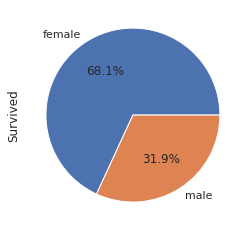

In [8]:
## 밑의 파이 그래프를 확인한 결과 여성이 남성보다 많이 살아 남았음을 확인 할 수 있다
## 그래서 머신러닝에서 활용하기 위해서 남자와 여자라는 스트링 형태를  남자는 0 여자는 1의 데이터로 바꿔준다
df = train_df[['Survived','Sex']]
df_Sex=df.groupby('Sex').sum()
df_Sex['Survived'].plot(kind='pie', autopct='%1.1f%%')

In [9]:
def Sex_apply(Sex):
  if Sex=='male':
    return 0
  else:
    return 1
  

In [10]:
## Sex 의 male은 1로 Sex의 female 은 2로

train_df['Sex'] = train_df['Sex'].apply(Sex_apply)
test_df['Sex'] = test_df['Sex'].apply(Sex_apply)

In [11]:
##이름에 담겨있는 정보를 파악하기 위해 이름을 regular expression 정규 표현식을 사용해서 추출을 해줍니다.
# 목표는 이름에서 Mr.Miss 등의 특정한 작위나 신분을 나타내는 문자열만 가져오는 것입니다.


#train_df['Name'].value_counts()
Name=train_df.Name.str.extract(' ([a-zA-Z]+)\.')

Name1 =test_df.Name.str.extract(' ([a-zA-Z]+)\.')

Name=np.array(Name[0].tolist())

Name1=np.array(Name[1].tolist())

train_df['Name'] = Name


test_df['Name'] = Name1

In [12]:
## 데이터 셋과 트레인셋의 이름을 모두 Mr등의 형태로 변환했으므로 범주형 형태로 바꿔줍니다.


for dataset in combine:
    dataset['Name'] = dataset['Name'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Name'] = dataset['Name'].replace('Mlle', 'Miss')
    dataset['Name'] = dataset['Name'].replace('Ms', 'Miss')
    dataset['Name'] = dataset['Name'].replace('Mme', 'Mrs')
    dataset['Name'] = dataset['Name'].replace('Mr', '1')
    dataset['Name'] = dataset['Name'].replace('Miss', '2')
    dataset['Name'] = dataset['Name'].replace('Mrs', '3')
    dataset['Name'] = dataset['Name'].replace('Master', '4')
    dataset['Name'] = dataset['Name'].replace('Rare', '5')

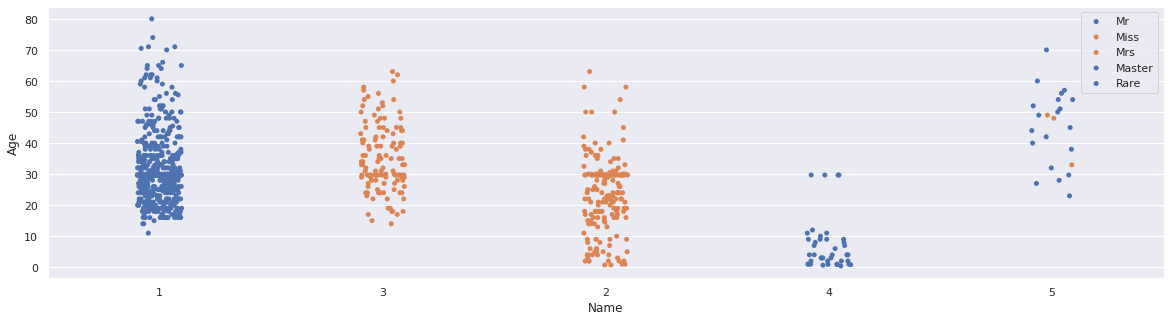

In [13]:
 ## Mr.Miss,Mrs는 상관이없지만 Master와 Rare의 성별 분포는 어떤지 확인해보겠습니다
## 이름의 범주에 따라 어떤 사람들이 존재하는지 봅니다.

fig=plt.figure(figsize=(20,5))
sns.stripplot(x='Name', y='Age',hue='Sex' ,data=train_df)
plt.legend(labels = ['Mr','Miss','Mrs','Master','Rare'],loc = 'best')

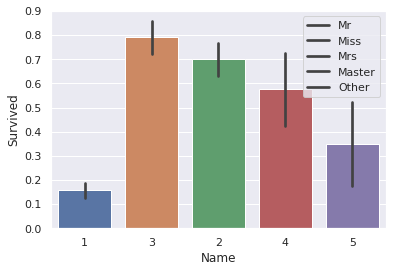

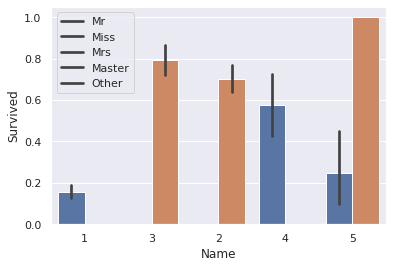

In [14]:
#bar그래프를 통해서 생존률이 어떻게 되는지 확인해봅니다.

sns.barplot(x='Name', y='Survived' ,data = train_df)
plt.legend(labels = ['Mr','Miss','Mrs','Master','Other'],loc = 'best')
plt.show()
sns.barplot(x='Name', y='Survived' ,data = train_df, hue='Sex')
plt.legend(labels = ['Mr','Miss','Mrs','Master','Other'],loc = 'best')
plt.show()


In [15]:
## SibSp와 Parch 특성을 합쳐서 F_size(패밀리사이즈)의 형태로 만들어 줍니다.



train_df['F_size'] =train_df['SibSp']+train_df['Parch'] +1
test_df['F_size'] =test_df['SibSp']+test_df['Parch'] +1

In [16]:
## F_size = 0인 경우는 동승자가 1명이상인 탑승객 이라는 뜻입니다.

def F_size_apply(F_size):
  if F_size ==1:
    return 1
  else:
    return 0

In [17]:
## apply 함수를 통해서 가족이 없다면 1있다면 0을 부여하여 범주화 해줍니다.

train_df['F_size'] = train_df['F_size'].apply(F_size_apply)
test_df['F_size'] = test_df['F_size'].apply(F_size_apply) 


In [18]:
#F_size의 형태로 가족(동승원)의 수를 통합해줬으니 필요없는 특성을 제거합니다.
train_df = train_df.drop(['SibSp','Parch'],axis='columns')
test_df = test_df.drop(['SibSp','Parch'],axis='columns')
combine = [train_df,test_df]

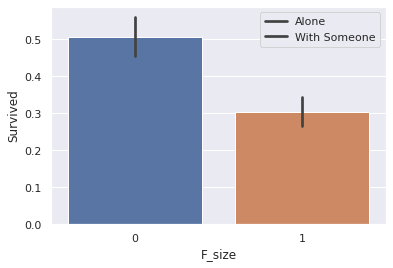

In [19]:
#barplot을 통해서 혼자일때와 누군가 동승자가 잇을때의 생존여부의 차이를 확인해봅니다.


sns.barplot(x='F_size', y='Survived' ,data = train_df)
plt.legend(labels = ['Alone','With Someone'],loc = 'best')

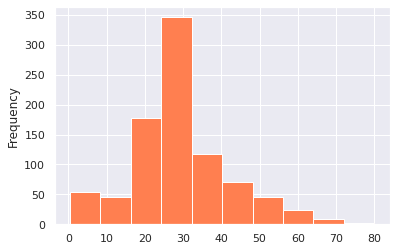

In [20]:
## Age특성을 확인해본 결과 나이의 분포입니다. 데이터를 범주형 데이터로 변환해 주겠습니다.

train_df['Age'].plot(kind='hist', color='coral')
plt.show()

In [21]:
## Ageband= Age를 판다스 cut을 사용해 5등분한 범위를 나타내는 지표입니다
train_df['Ageband'] = pd.cut(train_df['Age'],5)
test_df['Ageband'] = pd.cut(test_df['Age'],5)

In [22]:
## 나눠진 범위는 [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] <(48.168, 64.084] < (64.084, 80.0]] 입니다
## 따라서 정수범위를 설정하여 Age를 [0,1,2,3,4]로 범주화 하겠습니다.

for dataset in combine:

  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [23]:
##'Ageband 특성은 필요가 없으므로 제거해 주겠습니다.
train_df = train_df.drop(['Ageband'], axis=1)
test_df = test_df.drop(['Ageband'], axis=1)
combine = [train_df,test_df]

<Axes: xlabel='Age', ylabel='Survived'>

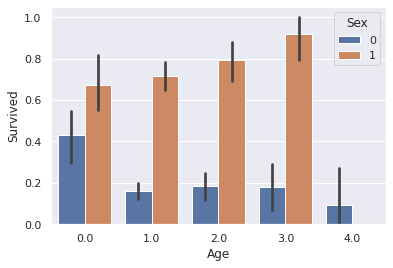

In [24]:
## 그래프로 확인한 결과 어린 나이대일수록 여성일수록 생존률이 좋습니다.

sns.barplot(x='Age', y='Survived' ,data = train_df, hue='Sex')

In [25]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

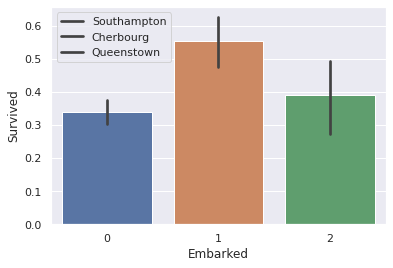

In [26]:
sns.barplot(x='Embarked', y='Survived' ,data = train_df)
plt.legend(labels = ['Southampton', 'Cherbourg', 'Queenstown'],loc = 'best')

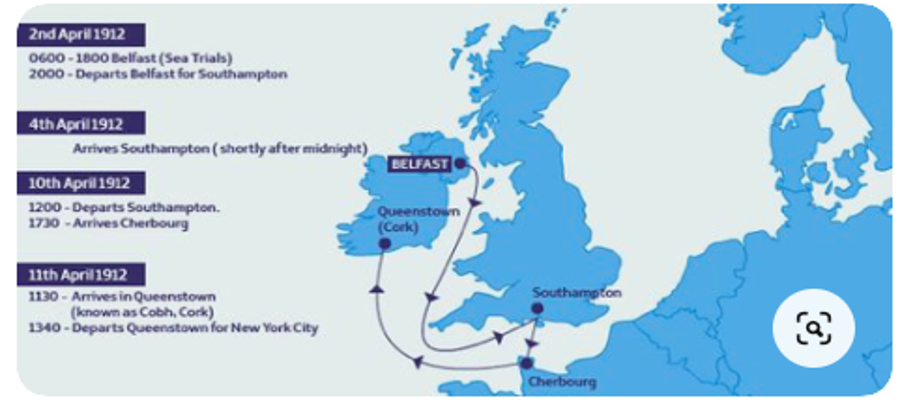

In [27]:
image =Image.open('Titanic_Route.png')
image1 = image.resize((900, 400))
image1.show()

In [28]:
## test 데이터의 Fare 특성에 하나의 결측치가 존재하므로 중간값으로 채워주겠습니다.

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    int64  
 3   Age       418 non-null    float64
 4   Fare      418 non-null    float64
 5   Embarked  418 non-null    int64  
 6   F_size    418 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 23.0+ KB


In [29]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [30]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
## 데이터를 age와 같은 방법으로 처리합니다.
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    

<Axes: xlabel='Fare', ylabel='count'>

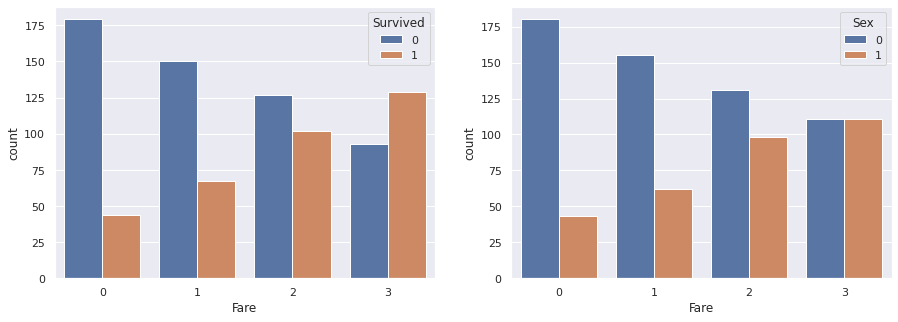

In [31]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.countplot(x='Fare', hue='Survived', data=train_df, ax=ax1)

sns.countplot(x='Fare', hue='Sex', data=train_df, ax=ax2)


In [32]:
## train데이터의 최종형태는 타깃값을 제외한 7개의 특성을 범주화 하는 작업을 하였습니다.

train_df.head(5)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,F_size
0,0,3,1,0,1.0,0,0,0
1,1,1,3,1,2.0,3,1,0
2,1,3,2,1,1.0,1,0,1
3,1,1,3,1,2.0,3,0,0
4,0,3,1,0,2.0,1,0,1


In [33]:
test_df.head(5)

,Pclass,Name,Sex,Age,Fare,Embarked,F_size
0,3,3,0,2.0,0,2,1
1,3,3,1,2.0,0,0,0
2,2,3,0,3.0,1,2,1
3,3,3,0,1.0,1,0,1
4,3,3,1,1.0,1,0,0


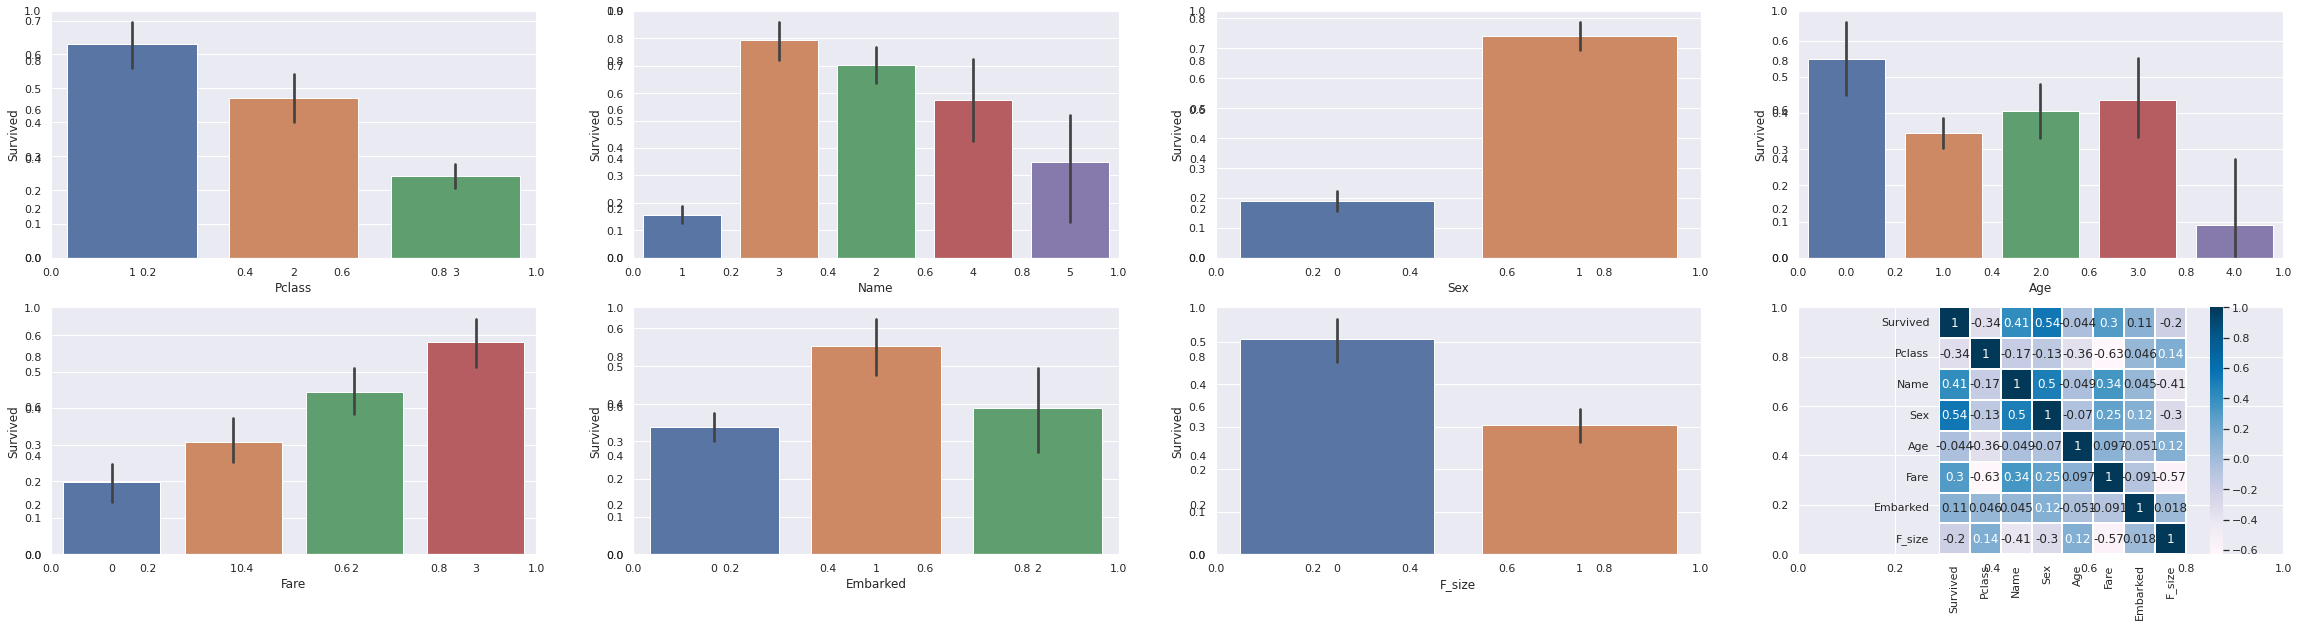

In [34]:
## 앞에서  전처리하여 범주화한 모든 데이터에 대하여 y(Survived)에 대한 대응 그래프를 그려 보도록하겠습니다
## train_df의 Survived 특성을 제외한 7개의 특성에 대한 그래프와 마지막 한자리에 correlation 히트맵을 그리겠습니다.
draw_list= train_df.columns[1:].tolist()
fig=plt.figure(figsize=(40,10))
ax1 =fig.add_subplot(2,4,1)
ax2 =fig.add_subplot(2,4,2)
ax3 =fig.add_subplot(2,4,3)
ax4 =fig.add_subplot(2,4,4)
ax5 =fig.add_subplot(2,4,5)
ax6 =fig.add_subplot(2,4,6)
ax7 =fig.add_subplot(2,4,7)
ax8 =fig.add_subplot(2,4,8)


for i in draw_list:
  j=draw_list.index(i)+1
  sns.barplot(x= i, y= 'Survived',data =train_df, ax=fig.add_subplot(2,4,j))

colormap = plt.cm.PuBu
sns.heatmap(train_df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot=True, ax =fig.add_subplot(2,4,8))
plt.show()

In [35]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"] #X_target
X_test  = test_df
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [36]:
classifiers=[LogisticRegression(),SVC(C=1),KNeighborsClassifier(n_neighbors = 10),GaussianNB(),LinearSVC(C=25),SGDClassifier(loss='huber'),DecisionTreeClassifier(max_depth=5, min_impurity_decrease=0.0001,min_samples_split=92),
             RandomForestClassifier(n_estimators=100)]
      
classifier_names = ['Logistic','SVC','Kn','Gau','LinearSVC','SGD','DT','RF']

modelaccuracies = []
modelmeans= []
modelnames = []
models = pd.DataFrame({'Model_name':[],'Score':[]})
classifier_data = zip(classifier_names,classifiers)
for classifier_name, classifier in classifier_data:
  classifier.fit(X_train,Y_train)
  Y_pred = classifier.predict(X_test)
  acc = round(classifier.score(X_train, Y_train) * 100, 2)
  modelaccuracies.append(round(classifier.score(X_train, Y_train) * 100, 2))
  modelnames.append(classifier_name)
  modelmeans.append(acc.mean())
  new_model = {'Model_name':classifier_name, 'Score':acc}
  models = models.append(new_model,ignore_index=True)


<ipython-input-36-4e4776b793e8>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_model,ignore_index=True)
<ipython-input-36-4e4776b793e8>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_model,ignore_index=True)
<ipython-input-36-4e4776b793e8>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_model,ignore_index=True)
<ipython-input-36-4e4776b793e8>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(new_model,ignore_index=True)
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to co

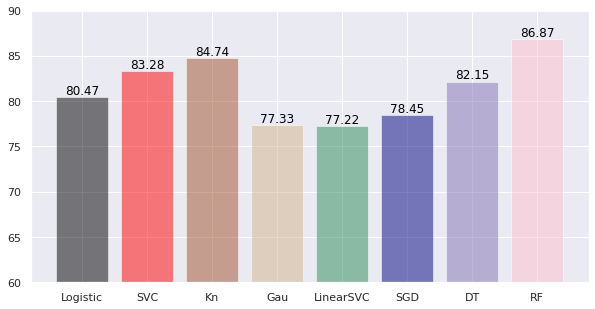

In [37]:
plt.figure(figsize=(10,5))
ax =fig.add_subplot(111)
plt.ylim([60,90])

x =models['Model_name']
y =models['Score']

plt.bar(x,y, color = ['black', 'red', 'sienna', 'tan','seagreen','navy','m','pink'], alpha = 0.5)

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')

plt.show()

In [42]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.87

In [43]:
test_df = pd.read_csv('./test.csv')

In [44]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submission.csv', index=False)